**Upload data**

In [55]:
# download SeaNMF repo from github
!git clone https://github.com/tshi04/SeaNMF 

Cloning into 'SeaNMF'...
remote: Enumerating objects: 103, done.
remote: Total 103 (delta 0), reused 0 (delta 0), pack-reused 103
Receiving objects: 100% (103/103), 16.29 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [56]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [57]:
pip install --upgrade gensim

In [58]:
pip install pyldavis==3.2.1

In [59]:
# download data
%cd /content

#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz
#!gzip -d Luxury_Beauty_5.json.gz
#!mv Luxury_Beauty_5.json data1.json

!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Office_Products.json.gz
!gzip -d Office_Products.json.gz
!mv Office_Products.json data1.json

#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Gift_Cards_5.json.gz
#!gzip -d Gift_Cards_5.json.gz
#!mv Gift_Cards_5.json data1.json

#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Magazine_Subscriptions_5.json.gz
#!gzip -d Magazine_Subscriptions_5.json.gz
#!mv Magazine_Subscriptions_5.json data2.json

#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Appliances_5.json.gz
#!gzip -d Appliances_5.json.gz
#!mv Appliances_5.json data3.json

/content
--2022-04-18 13:19:24--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Office_Products.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698526945 (666M) [application/octet-stream]
Saving to: ‘Office_Products.json.gz’

Office_Products.jso 100%[===================>] 666.17M  19.1MB/s    in 35s     

2022-04-18 13:20:00 (18.9 MB/s) - ‘Office_Products.json.gz’ saved [698526945/698526945]



In [60]:
data_path = "data.json"
data_paths = ["data1.json"]
#data_paths = ["data1.json", "data2.json", "data3.json"]

In [61]:
import json
%cd /content

texts = []
reviewTimes = set()
reviewTimesList = []
reviewTextList = []

for data_path in data_paths:
  dataset = open(data_path, "r")
  lines = dataset.readlines()
  print("Processing dataset: ", data_path, " Corpus_size:", len(lines))
  for line_idx, line in enumerate(lines):
      d = json.loads(line)
      if "reviewText" in d:
        texts.append(d["reviewText"])

# random shuffle and cut texts
MAX_LENGTH = 40000
print("0:", texts[0], "\n1:", texts[1])
np.random.shuffle(texts)
print("Shuffel: ")
print("0:", texts[0], "\n1:", texts[1])
print(len(texts))
texts = texts[0:MAX_LENGTH]
print("0:", texts[0], "\n1:", texts[1])
print(len(texts))

with open("data.txt", "w") as f: 
  for text in texts:
        f.write(text)

# delete old data from repo
!rm SeaNMF/data/*

# copy new data as text file from Amazon review data in repo directory
!mv data.txt SeaNMF/data/data.txt   

# check dataset
print("All length:", len(texts))

/content
Processing dataset:  data1.json  Corpus_size: 5581313
0: I thought the book was entertaining and cute, and an introduction to what goes on at a laundromat. However, I don't think I would get this book for a young todder (under 4) due to the fact that there was one scene where Corduroy is alone in the dark of laudromat, inside a wired laundry cart, and he looks terrified. The picture is very scary and sad. I think it's too much for a little kid. But overall, it's cute, and the ending is good. 
1: This adorable story is an all time favorite fantasy. Although at first it seems as if the story is realistic, it's not long before the teddy bear is up walking and talking.
Shuffel: 
0: As expected. 
1: Love how these feel and they are super pretty.
5578483
0: As expected. 
1: Love how these feel and they are super pretty.
40000
All length: 40000


**Data pre-processing**

In [62]:
# remove punctuation and non-alphabetical symbols
# change uppercase letter in lowercase letter
# tokenize the data

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

texts_tokenized = list(sent_to_words(texts))

print(texts_tokenized [10])

['did', 'not', 'work', 'at', 'all', 'would', 'not', 'buys', 'this']


In [63]:
# stopwords

!pip install stop_words

from stop_words import get_stop_words
stop_words = list(get_stop_words('en'))   # about 900 stopwords

print(stop_words [:10])

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']


In [64]:
# remove stopwords

def remove_stopwords(incoming_text):
    return [word for word in simple_preprocess(str(incoming_text)) if word not in stop_words]

texts_no_stopwords = []

for token_idx, token_list in enumerate((texts_tokenized)):
  token_list_no_stopwords = remove_stopwords(token_list)
  texts_no_stopwords.append(token_list_no_stopwords)
  if token_idx == 10:
    print("Before: ", token_list)
    print("After: ", token_list_no_stopwords)

print(texts_no_stopwords[10])

Before:  ['did', 'not', 'work', 'at', 'all', 'would', 'not', 'buys', 'this']
After:  ['work', 'buys']
['work', 'buys']


In [65]:
# bigrams/ trigrams
bigram = gensim.models.Phrases(texts_no_stopwords, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[texts_no_stopwords], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_words_bigrams = []

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

texts_words_bigrams = make_bigrams(texts_no_stopwords)
print(texts_words_bigrams[10])

texts_words_trigrams = make_trigrams(texts_no_stopwords)
print(texts_words_trigrams[10])

['work', 'buys']
['work', 'buys']


In [66]:
# lemmatization with spaCy
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

texts_lemmatized = []

def lemmatization(incoming_text):
    texts_out = []
    for text_idx, text_words_trigrams in enumerate(texts_words_trigrams):
        if text_idx%1000==0:
          print(f"Lemmatize: {text_idx}/{len(texts_words_trigrams)}")
        doc = nlp(" ".join(text_words_trigrams))
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

texts_lemmatized = lemmatization(texts_words_trigrams)
print(texts_lemmatized[10])

Output hidden; open in https://colab.research.google.com to view.

In [67]:
# check pre-processing steps
print(texts_tokenized [10])
print(texts_no_stopwords[10])
print(texts_words_trigrams[10])
print(texts_lemmatized[10])

['did', 'not', 'work', 'at', 'all', 'would', 'not', 'buys', 'this']
['work', 'buys']
['work', 'buys']
['work', 'buy']


In [68]:
texts_reduced = texts_lemmatized
print(texts_lemmatized[10])
print(texts_reduced[10])

['work', 'buy']
['work', 'buy']


In [69]:
# generate text document

with open("data_cleaned.txt", "w") as f: 
  for text_reduced in texts_reduced :
      f.writelines(" ".join(text_reduced) + "\n")
    
# copy new data as text file in repo directory
!cp data_cleaned.txt SeaNMF/data/data.txt

**Data information**

In [70]:
# number of documents (reviews)
print("Number of documents:",len(texts_reduced))

# word number of vocabulary
corpus_word_lengths = []
for text_reduced in texts_reduced:
  corpus_word_lengths.append(len(text_reduced))
print("Number of word:", np.sum(corpus_word_lengths))

# average word number of review
mean_word_length = np.mean(corpus_word_lengths)
print("Mean word lenght:", mean_word_length)

Number of documents: 40000
Number of word: 760666
Mean word lenght: 19.01665


In [71]:
# check
with open("/content/SeaNMF/data/data.txt", "r") as f:
    documents = f.readlines()

with open("/content/SeaNMF/data/data.txt", "r") as f:
    data = f.read()
    words = data.split()

print('Word number in cleaned corpus :', len(words))
print('Document number in cleaned corpus :', len(documents))


Word number in cleaned corpus : 760666
Document number in cleaned corpus : 40000


In [72]:
# word frequency

from nltk import FreqDist
import itertools
all_tokens = itertools.chain(*texts_reduced)
word_frequency = FreqDist(all_tokens)

print(word_frequency)
word_frequency.most_common(25)

<FreqDist with 20485 samples and 760666 outcomes>


[('use', 12166),
 ('work', 10379),
 ('great', 10297),
 ('good', 7857),
 ('one', 7769),
 ('get', 6717),
 ('printer', 6257),
 ('well', 6122),
 ('buy', 5943),
 ('just', 5737),
 ('will', 5651),
 ('like', 5645),
 ('product', 5581),
 ('can', 5510),
 ('love', 5413),
 ('pen', 4909),
 ('ink', 4872),
 ('time', 4604),
 ('make', 4369),
 ('quality', 4360),
 ('print', 4360),
 ('paper', 4230),
 ('price', 4160),
 ('need', 4116),
 ('look', 3842)]

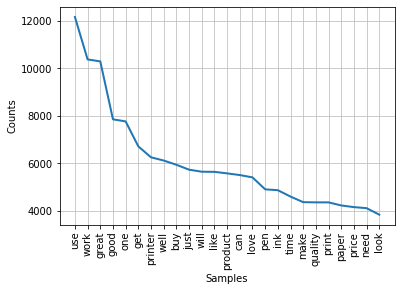

In [105]:
word_frequency.plot(25,cumulative=False) # cumulative=True

In [74]:
word_frequency.tabulate(25,cumulative=False)

    use    work   great    good     one     get printer    well     buy    just    will    like product     can    love     pen     ink    time    make quality   print   paper   price    need    look 
  12166   10379   10297    7857    7769    6717    6257    6122    5943    5737    5651    5645    5581    5510    5413    4909    4872    4604    4369    4360    4360    4230    4160    4116    3842 


In [75]:
# words that only appear once
#word_frequency.hapaxes()

**SeaNMF Model**

In [76]:
# SeaNMF Model
%cd /content/SeaNMF
!python3 data_process.py --vocab_max_size 100000

/content/SeaNMF
create vocab
create document term matrix


In [77]:
# training help
#!python3 train.py --help

In [78]:
# training with default values
# e.g. topics can be specified with !python3 train.py --n_topics 10
!python3 train.py --n_topics 100

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
calculate co-occurance matrix
co-occur done
--------------------------------------------------
calculate PPMI
PPMI done
--------------------------------------------------
read term doc matrix
tcmalloc: large alloc 2455363584 bytes == 0x561b24592000 @  0x7f32f4f7f001 0x7f32f288e1af 0x7f32f28e4c23 0x7f32f28e5a87 0x7f32f2987823 0x561b0698d11c 0x561b0698cef0 0x561b06a01123 0x561b069fba2e 0x561b069fb723 0x561b06ac5812 0x561b06ac5b8d 0x561b06ac5a36 0x561b06a9d183 0x561b06a9ce2c 0x7f32f3d67c87 0x561b06a9cd0a
term doc matrix done
--------------------------------------------------
loop begin
tcmalloc: large alloc 2455363584 bytes == 0x561bba1c2000 @  0x7f32f4f7d1e7 0x7f32f288e0ce 0x7f32f28e4cf5 0x7f32f28e4e80 0x7f32f28d9e6a 0x7f32f2b60605 0x7f32f2982eb0 0x7f32f2986b8e 0x561b0698f408 0x7f32f28cf944 0x561b0698d0e7 0x561b0698cef0 0x561b06a0

In [79]:
# count Pointwise Mutual Information (PMI)
from SeaNMF.utils import *

docs = read_docs("data/doc_term_mat.txt")
#print(docs)
vocab = read_vocab("data/vocab.txt")
#print(vocab)
#print(len(vocab))
n_docs = len(docs)
n_terms = len(vocab)
print('n_docs={}, n_terms={}'.format(n_docs, n_terms))

dt_mat = np.zeros([n_terms, n_terms])
for itm in docs:
    for kk in itm:
        for jj in itm:
            if kk != jj:
                dt_mat[int(kk), int(jj)] += 1.0
print('co-occur done')
#print(dt_mat)
        
W = np.loadtxt("seanmf_results/W.txt", dtype=float)
#print(W[12,1]) # W[x,y] = distribution of word x (row) & topic y (column) in W
n_topic = W.shape[1]
print('n_topic={}'.format(n_topic))

PMI_arr = []
n_topKeyword = 10
for k in range(n_topic):
    topKeywordsIndex = W[:,k].argsort()[::-1][:n_topKeyword]
      #print(W[:,k].argsort()[::-1][:n_topKeyword])
    PMI_arr.append(calculate_PMI(dt_mat, topKeywordsIndex))
print('Average PMI={}'.format(np.average(np.array(PMI_arr))))

index = np.argsort(PMI_arr)

topics_vocabs = []
  
for k in index:
    print('Topic ' + str(k+1) + ': ', end=' ')
    print(PMI_arr[k], end=' ')
    topic_vocab = []
    for w in np.argsort(W[:,k])[::-1][:n_topKeyword]:
        topic_vocab.append(vocab[w])
        print(vocab[w], end=' ')
    print()
    topics_vocabs.append(topic_vocab)

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
co-occur done
n_topic=100
Average PMI=2.879066398173505
Topic 98:  0.059918588222016136 use also ve hold may find keep much many since 
Topic 83:  0.06628496605838569 good price far pretty ever thing value find deal size 
Topic 86:  0.07107086411009307 just want don fine right say think little go way 
Topic 85:  0.09010155067040013 one two first another find new unit want side old 
Topic 84:  0.09512416392427456 make much thing sure little go feel plastic two also 
Topic 2:  0.09590761332114477 work fine perfectly try didn problem home doesn still now 
Topic 91:  0.12300153993054552 can see say find also even line easily button program 
Topic 70:  0.14556384346365359 will go review say long see last now update set 
Topic 88:  0.14597543490703957 get go try take back say thing think don know 
Topic 99:  0.1637472417775055 well mu

In [80]:
# count coherence u_mass
id2word = corpora.Dictionary(texts_reduced) # all_tokens --> gleich wie vocab nur, das in vocab wörter < 4 nicht drin sind
print(id2word)

# term-document-frequency
corpus = [id2word.doc2bow(text) for text in texts_reduced]

Dictionary(20485 unique tokens: ['expect', 'feel', 'love', 'pretty', 'super']...)


In [81]:
from gensim.test.utils import common_corpus, common_dictionary

from gensim.models.coherencemodel import CoherenceModel

topics = topics_vocabs

cm = CoherenceModel(topics=topics, texts= all_tokens,corpus=corpus, dictionary=id2word, coherence='u_mass')

coherence = cm.get_coherence()  # get coherence value
print(coherence)

-2.589121433934963


In [82]:
# visualize topics/ keywords/ Pointwise Mutual Information (PMI)
!python3 vis_topic.py

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
co-occur done
n_topic=100
Average PMI=2.879066398173505
Topic 98:  0.059918588222016136 use also ve hold may find keep much many since 
Topic 83:  0.06628496605838569 good price far pretty ever thing value find deal size 
Topic 86:  0.07107086411009307 just want don fine right say think little go way 
Topic 85:  0.09010155067040013 one two first another find new unit want side old 
Topic 84:  0.09512416392427456 make much thing sure little go feel plastic two also 
Topic 2:  0.09590761332114477 work fine perfectly try didn problem home doesn still now 
Topic 91:  0.12300153993054552 can see say find also even line easily button program 
Topic 70:  0.14556384346365359 will go review say long see last now update set 
Topic 88:  0.14597543490703957 get go try take back say thing think don know 
Topic 99:  0.1637472417775055 well mu

In [83]:
# visualize with pyLDAvis
import pyLDAvis

# create data for visualization
term_frequency = np.zeros(len(vocab)) # term frequencies
for doc in texts_reduced:
  for word in doc:
    #print(word)
    if word in vocab:
      index = vocab.index(word)
      term_frequency[index]+=1

doc_lengths = [len(doc) for doc in docs] # document lengths

W = np.loadtxt("seanmf_results/W.txt", dtype=float) # W = topic-term distribution matrix
H = np.loadtxt("seanmf_results/H.txt", dtype=float) # H = document-topic distribution matrix
row_sums = H.sum(axis=1)
H_normed_col = H / row_sums[:,  np.newaxis] # Apparently must be normalized across columns, otherwise pyLDAvis gives error

data_dict = {'topic_term_dists': W.T, 'doc_topic_dists': H_normed_col,
            'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_frequency}
data_vis = pyLDAvis.prepare(**data_dict)
pyLDAvis.display(data_vis)

Output hidden; open in https://colab.research.google.com to view.

**LDA**

In [84]:
# create dictionary
id2word = corpora.Dictionary(texts_reduced)
print(id2word[2])

# create corpus
texts = texts_reduced

# Term-Document-Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

# human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[0:1]]

love
[(0, 1)]


[[('expect', 1)]]

In [85]:
# LDA model with default values
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            num_topics=100, 
                                            id2word=id2word,
                                            alpha=0.1, 
                                            eta=0.01, 
                                            decay=0.5,
                                            iterations=2000)

In [86]:
# count Pointwise Mutual Information (PMI)
# PMI:term-topic matrix
topic_term_matrix = lda_model.get_topics()
#print(topic_term_matrix) 

# change rows and columns --> result: rows = terms/ columns = topics
np.transpose(lda_model.get_topics())

term_topic_matrix = np.transpose(lda_model.get_topics())

#print(term_topic_matrix)
print(term_topic_matrix[0,1])

1.5559395e-06


In [87]:
# PMI:numbers of topics
print(lda_model.num_topics)

# PMI:word2id
word2id = {v: k for k,v in id2word.items()}
print(word2id)

# texts as numbers
texts_as_numbers = []
for text in texts:
  text_as_number = []
  for word in text:
    text_as_number.append(word2id[word])
  texts_as_numbers.append(text_as_number)

# write texts as numbers as file
with open("data_as_numbers.txt", "w") as f: 
  for text in texts_as_numbers:
    #print(" ".join(text_no_stopwords))
    f.writelines(' '.join([str(word) for word in text]) + "\n")

# write vocabulary with word_frequency as file
with open("vocabulary.txt", "w") as f: 
  for k,v in word_frequency.items():
    #print(" ".join(text_no_stopwords))
    f.writelines(f"{k} {v}" + "\n")

100
{'expect': 0, 'feel': 1, 'love': 2, 'pretty': 3, 'super': 4, 'also': 5, 'clearly': 6, 'come': 7, 'cord': 8, 'description': 9, 'easily': 10, 'expecting': 11, 'go': 12, 'kangaroo': 13, 'like': 14, 'match': 15, 'may': 16, 'now': 17, 'one': 18, 'orange': 19, 'order': 20, 'pay': 21, 'seem': 22, 'separately': 23, 'specify': 24, 'stencil': 25, 'top': 26, 'wear': 27, 'will': 28, 'nice': 29, 'cheap': 30, 'look': 31, 'door': 32, 'effective': 33, 'large': 34, 'small': 35, 'easy': 36, 'red': 37, 'rockabilly': 38, 'teal': 39, 'wed': 40, 'wedding': 41, 'cartridge': 42, 'color': 43, 'device': 44, 'hp_photosmart': 45, 'suppose': 46, 'work': 47, 'exactly': 48, 'want': 49, 'card': 50, 'card_stock': 51, 'classroom': 52, 'complete': 53, 'continue': 54, 'craft': 55, 'do': 56, 'epson': 57, 'get': 58, 'great': 59, 'jam': 60, 'letter_sized': 61, 'mt': 62, 'past': 63, 'printer': 64, 'product': 65, 'since': 66, 'stock': 67, 'student': 68, 'use': 69, 'useful': 70, 'buy': 71, 'don': 72, 'excellent': 73, 'high

In [88]:
def read_docs(file_name):
    print('read documents')
    print('-'*50)
    docs = []
    fp = open(file_name, 'r')
    for line in fp:
        arr = re.split('\s', line[:-1])
        arr = filter(None, arr)
        arr = [int(idx) for idx in arr]
        docs.append(arr)
    fp.close()
    
    return docs

def read_vocab(file_name):
    print('read vocabulary')
    print('-'*50)
    vocab = []
    fp = open(file_name, 'r')
    for line in fp:
        arr = re.split('\s', line[:-1])
        vocab.append(arr[0])
    fp.close()

    return vocab

<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:21: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:21: DeprecationWarning: invalid escape sequence \s
<input>:7: DeprecationWarning: invalid escape sequence \s
<input>:21: 

In [89]:
docs = read_docs('/content/SeaNMF/data_as_numbers.txt')
print(docs)
vocab = read_vocab('/content/SeaNMF/vocabulary.txt')
#print(vocab)
#print(len(vocab))
#sorted(vocab)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
# PMI:number of documents/ terms
n_docs = len(docs)
n_terms = len(vocab)
print('n_docs={}, n_terms={}'.format(n_docs, n_terms))

n_docs=40000, n_terms=20485


In [91]:
# PMI:data_matrix
dt_mat = np.zeros([n_terms, n_terms])
for itm in docs:
    for kk in itm:
        for jj in itm:
            if kk != jj:
                dt_mat[int(kk), int(jj)] += 1.0
print('co-occur done')
print(dt_mat[0:10, 0:10])

co-occur done
[[  0. 107. 153. 107.  44. 193.  12. 227.  24.  28.]
 [107.   0. 302. 170.  48. 360.  27. 288.  17.  22.]
 [153. 302.   0. 201. 155. 559.  23. 540.  26.  24.]
 [107. 170. 201.   0.  51. 262.  13. 224.  12.  14.]
 [ 44.  48. 155.  51.   0.  93.   5.  99.   1.   9.]
 [193. 360. 559. 262.  93.   0.  49. 659.  73.  37.]
 [ 12.  27.  23.  13.   5.  49.   0.  34.   9.   9.]
 [227. 288. 540. 224.  99. 659.  34.   0.  73.  63.]
 [ 24.  17.  26.  12.   1.  73.   9.  73.   0.   3.]
 [ 28.  22.  24.  14.   9.  37.   9.  63.   3.   0.]]


In [92]:
# PMI:define PMI calculation
def calculate_PMI(AA, topKeywordsIndex):
    '''
    Reference:
    Short and Sparse Text Topic Modeling via Self-Aggregation
    '''
    D1 = np.sum(AA)
    n_tp = len(topKeywordsIndex)
    PMI = []
    for index1 in topKeywordsIndex:
        for index2 in topKeywordsIndex:
            if index2 < index1:
                if AA[index1, index2] == 0:
                    PMI.append(0.0)
                else:
                    C1 = np.sum(AA[index1])
                    C2 = np.sum(AA[index2])
                    PMI.append(np.log(AA[index1,index2]*D1/C1/C2))
    avg_PMI = 2.0*np.sum(PMI)/float(n_tp)/(float(n_tp)-1.0)

    return avg_PMI

    print()

In [93]:
# PMI:calculate PMI
PMI_arr = []
n_topKeyword = 10
for k in range(lda_model.num_topics):
  #print(term_topic_matrix[:,k].argsort()[::-1][:n_topKeyword])
  topKeywordsIndex = term_topic_matrix[:,k].argsort()[::-1][:n_topKeyword]
  print(topKeywordsIndex)
  PMI_arr.append(calculate_PMI(dt_mat, topKeywordsIndex))
print('Average PMI={}'.format(np.average(np.array(PMI_arr))))

[ 463  168  329  466  454 1835  586   77 1363   35]
[ 897  698  600  171 2461 2467  646  584 1120  884]
[ 341 2006   60 1708   54 1203  898 1034   53  910]
[  78   79  528  552  591 1460 1212   80 1476 3474]
[ 170  457  585  545  584 1022  581  847   18   14]
[ 499  217  116  435  890 1419  338  851 1795 1279]
[ 103  333  432  869 1070  349 1012 1935 2651 4453]
[ 114  834  208  519  537 1187  302   69   22   47]
[  59   65  100   99  947 1628 2516  515   85 2032]
[1023  251  556  355   69 1257  241  609  431  804]
[ 312 1120  113 1804  859   69  625  531  983   18]
[ 198  830  119 1256 1599 1420   69 1276 2738  105]
[ 578  286  761   69 1633  229 1181 1337  197 2120]
[ 325  257   44 1845  668 3002  367 1759  745  261]
[ 157  681 1086 2175 2501 1554  131  642   47 3182]
[   1  276  361   14 1857  801 2685 1848  574 3888]
[ 559  109   26  788  427  573  561  407 1004  609]
[ 838  464 1473 1461  639 3849 1646 1501  914 1099]
[  34  188   69  907 1093    5  873  778  902 1769]
[ 791 1134 1

In [106]:
# PMI:PMI of topics
pprint(PMI_arr[0:])

[0.13127541583544539,
 0.16109309108386918,
 0.09808172474457241,
 0.12497294704466094,
 1.0446579916986876,
 0.07188785628663477,
 0.13943917835084244,
 1.025364353295501,
 0.8828504544139851,
 0.09670958874439106,
 0.3317435146346503,
 0.40430576466175616,
 0.3008238886178249,
 0.36978416604004694,
 0.5005007974369101,
 0.9506451063930166,
 0.11221115912651437,
 0.3749761024019241,
 0.17655106876178406,
 0.4320590909569796,
 1.0699584487477116,
 0.2413905640500628,
 0.09829287228518287,
 0.9948638490186215,
 1.6825972310761677,
 0.11795488373650828,
 0.16375986910222864,
 0.058563667252623026,
 0.4045431374843023,
 0.9204574783165153,
 -0.02263770108932896,
 0.20133328536567036,
 0.6895180536845954,
 0.276719291869937,
 0.18316728962338702,
 0.0881194178993386,
 0.14577512100079906,
 0.45904937741484847,
 0.37278848207956883,
 1.038839034010558,
 0.11931955647389793,
 0.2487121401793562,
 0.3593058994825127,
 0.17956787376017166,
 1.01489360534433,
 1.5701011485807301,
 0.50353463487

In [95]:
# compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is/ lower is better

# compute coherence score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_reduced, dictionary=id2word, coherence='c_v')
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_reduced, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.971933081073747

Coherence Score:  -5.3160453272701895


In [96]:
# visualize topics/ keywords + distributions
pprint(lda_model.print_topics(num_topics=100))
doc_lda = lda_model[corpus]

[(0,
  '0.133*"little" + 0.095*"big" + 0.083*"keep" + 0.067*"place" + '
  '0.034*"bottom" + 0.033*"inch" + 0.031*"enough" + 0.023*"put" + 0.021*"wide" '
  '+ 0.019*"small"'),
 (1,
  '0.076*"almost" + 0.063*"three" + 0.049*"couple" + 0.037*"break" + '
  '0.032*"later" + 0.030*"throw" + 0.029*"press" + 0.026*"two" + 0.025*"month" '
  '+ 0.025*"badge"'),
 (2,
  '0.097*"holder" + 0.067*"sell" + 0.065*"jam" + 0.050*"matter" + '
  '0.043*"continue" + 0.040*"tiny" + 0.033*"coin" + 0.032*"fix" + '
  '0.031*"complete" + 0.026*"early"'),
 (3,
  '0.091*"sheet" + 0.071*"shredder" + 0.039*"paper" + 0.037*"insert" + '
  '0.031*"empty" + 0.029*"cd" + 0.029*"feed" + 0.028*"time" + 0.026*"shred" + '
  '0.025*"chip"'),
 (4,
  '0.130*"box" + 0.119*"desk" + 0.073*"wish" + 0.066*"stand" + 0.048*"two" + '
  '0.038*"monitor" + 0.034*"ship" + 0.031*"assemble" + 0.029*"one" + '
  '0.020*"like"'),
 (5,
  '0.119*"always" + 0.108*"quickly" + 0.081*"dry" + 0.063*"run" + '
  '0.053*"already" + 0.052*"blue" + 0.036*

In [97]:
# visualize with pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
visualization

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
71     0.060423 -0.233385       1        1  3.008513
73     0.100419 -0.160032       2        1  2.145316
49     0.040992 -0.030630       3        1  1.885474
50     0.101999 -0.077291       4        1  1.865351
96    -0.111756  0.045802       5        1  1.855200
...         ...       ...     ...      ...       ...
32     0.068562 -0.003814      96        1  0.616588
87     0.004958  0.077397      97        1  0.605074
23    -0.032880  0.009499      98        1  0.601477
44    -0.027828 -0.058368      99        1  0.555268
53    -0.001484  0.107557     100        1  0.510118

[100 rows x 5 columns], topic_info=         Term         Freq         Total  Category  logprob  loglift
2        love  4739.000000   4739.000000   Default  30.0000  30.0000
59      great  7888.000000   7888.000000   Default  29.0000  29.0000
136       pen  4393.000000   4393.000000   Default  28.0000  28.0000
64    printer  5898.000000   5898.000000   Default  27.0000  27.0000
47       work  8987.000000   8987.000000   Default  26.0000  26.0000
...       ...          ...           ...       ...      ...      ...
1499    reuse    22.779372     24.580426  Topic100  -5.1378   5.2022
582      size    46.912848   1697.046446  Topic100  -4.4154   1.6899
69        use    48.341691  12826.508531  Topic100  -4.3854  -0.3027
14       like    32.860018   5868.634698  Topic100  -4.7714   0.0932
18        one    31.024763   8103.914111  Topic100  -4.8289  -0.2870

[4508 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
883      11  0.002246  -PRON-
883      46  0.001123  -PRON-
883      62  0.003370  -PRON-
883      66  0.654808  -PRON-
883      70  0.001123  -PRON-
...     ...       ...     ...
4338     96  0.967615   zebra
489      84  0.987503    zero
1017     71  0.008077  zipper
1017     77  0.008077  zipper
1017     92  0.977354  zipper

[13015 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[72, 74, 50, 51, 97, 56, 25, 9, 11, 99, 1, 79, 73, 87, 34, 19, 92, 100, 5, 48, 70, 44, 80, 46, 55, 77, 75, 60, 82, 14, 15, 10, 96, 4, 53, 81, 69, 2, 98, 32, 58, 8, 76, 37, 6, 42, 71, 85, 65, 17, 36, 35, 16, 90, 27, 66, 30, 63, 31, 84, 64, 26, 93, 29, 13, 21, 89, 68, 61, 20, 95, 38, 23, 83, 22, 41, 91, 62, 78, 86, 57, 3, 12, 47, 52, 40, 49, 59, 43, 7, 94, 28, 39, 67, 18, 33, 88, 24, 45, 54])

**NMF Model**

In [98]:
# NMF Model
%cd /content/SeaNMF
!python3 data_process.py --vocab_max_size 100000

/content/SeaNMF
create vocab
create document term matrix


In [99]:
# training with default values
# e.g. topics can be specified with !python3 train.py --n_topics 10
!python3 train.py --n_topics 100 --model='nmf'

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
read term doc matrix
tcmalloc: large alloc 2455363584 bytes == 0x55b3d743a000 @  0x7fae50be1001 0x7fae4e4f01af 0x7fae4e546c23 0x7fae4e547a87 0x7fae4e5e9823 0x55b3d531e11c 0x55b3d531def0 0x55b3d5392123 0x55b3d538ca2e 0x55b3d538c723 0x55b3d5456812 0x55b3d5456b8d 0x55b3d5456a36 0x55b3d542e183 0x55b3d542de2c 0x7fae4f9c9c87 0x55b3d542dd0a
term doc matrix done
--------------------------------------------------
loop begin
tcmalloc: large alloc 2455363584 bytes == 0x55b46c47e000 @  0x7fae50bdf1e7 0x7fae4e4f00ce 0x7fae4e546cf5 0x7fae4e546e80 0x7fae4e53be6a 0x7fae4e7c2605 0x7fae4e5e4eb0 0x7fae4e5e8b8e 0x55b3d5320408 0x7fae4e531944 0x55b3d531e0e7 0x55b3d531def0 0x55b3d53919a3 0x55b3d538ca2e 0x55b3d531f88a 0x55b3d5391d30 0x55b3d531f7aa 0x55b3d538db4f 0x55b3d531f7aa 0x55b3d538db4f 0x55b3d538ca2e 0x55b3d532013c 0x55b3d5361239 0x55b3d535e184 0

In [100]:
# count Pointwise Mutual Information (PMI)
from SeaNMF.utils import *

docs = read_docs("data/doc_term_mat.txt")
#print(docs)
vocab = read_vocab("data/vocab.txt")
#print(vocab)
#print(len(vocab))
n_docs = len(docs)
n_terms = len(vocab)
print('n_docs={}, n_terms={}'.format(n_docs, n_terms))

dt_mat = np.zeros([n_terms, n_terms])
for itm in docs:
    for kk in itm:
        for jj in itm:
            if kk != jj:
                dt_mat[int(kk), int(jj)] += 1.0
print('co-occur done')
#print(dt_mat)
        
W = np.loadtxt("seanmf_results/W.txt", dtype=float)
#print(W[12,1]) # W[x,y] = distribution of word x (row) & topic y (column) in W
n_topic = W.shape[1]
print('n_topic={}'.format(n_topic))

PMI_arr = []
n_topKeyword = 10
for k in range(n_topic):
    topKeywordsIndex = W[:,k].argsort()[::-1][:n_topKeyword]
      #print(W[:,k].argsort()[::-1][:n_topKeyword])
    PMI_arr.append(calculate_PMI(dt_mat, topKeywordsIndex))
print('Average PMI={}'.format(np.average(np.array(PMI_arr))))

index = np.argsort(PMI_arr)

topics_vocabs = []
  
for k in index:
    print('Topic ' + str(k+1) + ': ', end=' ')
    print(PMI_arr[k], end=' ')
    topic_vocab = []
    for w in np.argsort(W[:,k])[::-1][:n_topKeyword]:
        topic_vocab.append(vocab[w])
        print(vocab[w], end=' ')
    print()
    topics_vocabs.append(topic_vocab)

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
co-occur done
n_topic=100
Average PMI=0.621512721600102
Topic 31:  -0.02263770108932896 good far ever pretty value deal job overall idea choice 
Topic 73:  0.010682029618832316 can easily without either beat program read not name window 
Topic 48:  0.035485375860136094 see light picture something re lamp difference yet since hard 
Topic 100:  0.0504470057947432 well seem package worth build stick quite other far function 
Topic 28:  0.058563667252623026 quality high excellent poor sound notebook low cheap cost printing 
Topic 69:  0.06619340396722259 also able help feature show overall way case list many 
Topic 6:  0.07188785628663477 will another sure next probably definitely update yes full never 
Topic 79:  0.08354290120892133 just right way wish start describe bad deal bit advertise 
Topic 52:  0.08725659349944456 come didn 

In [101]:
# count coherence u_mass
id2word = corpora.Dictionary(texts_reduced) # all_tokens --> gleich wie vocab nur, das in vocab wörter < 4 nicht drin sind
print(id2word)

# term-document-frequency
corpus = [id2word.doc2bow(text) for text in texts_reduced]

Dictionary(20485 unique tokens: ['expect', 'feel', 'love', 'pretty', 'super']...)


In [102]:
from gensim.test.utils import common_corpus, common_dictionary

from gensim.models.coherencemodel import CoherenceModel

topics = topics_vocabs

cm = CoherenceModel(topics=topics, texts= all_tokens,corpus=corpus, dictionary=id2word, coherence='u_mass')

coherence = cm.get_coherence()  # get coherence value
print(coherence)

-3.2961713444171643


In [103]:
# visualize topics/ keywords/ Pointwise Mutual Information (PMI)
!python3 vis_topic.py

read documents
--------------------------------------------------
read vocabulary
--------------------------------------------------
n_docs=40000, n_terms=7673
co-occur done
n_topic=100
Average PMI=0.621512721600102
Topic 31:  -0.02263770108932896 good far ever pretty value deal job overall idea choice 
Topic 73:  0.010682029618832316 can easily without either beat program read not name window 
Topic 48:  0.035485375860136094 see light picture something re lamp difference yet since hard 
Topic 100:  0.0504470057947432 well seem package worth build stick quite other far function 
Topic 28:  0.058563667252623026 quality high excellent poor sound notebook low cheap cost printing 
Topic 69:  0.06619340396722259 also able help feature show overall way case list many 
Topic 6:  0.07188785628663477 will another sure next probably definitely update yes full never 
Topic 79:  0.08354290120892133 just right way wish start describe bad deal bit advertise 
Topic 52:  0.08725659349944456 come didn 

In [104]:
# visualize with pyLDAvis
import pyLDAvis

# create data for visualization
term_frequency = np.zeros(len(vocab)) # term frequencies
for doc in texts_reduced:
  for word in doc:
    #print(word)
    if word in vocab:
      index = vocab.index(word)
      term_frequency[index]+=1

doc_lengths = [len(doc) for doc in docs] # document lengths

W = np.loadtxt("seanmf_results/W.txt", dtype=float) # W = topic-term distribution matrix
H = np.loadtxt("seanmf_results/H.txt", dtype=float) # H = document-topic distribution matrix
row_sums = H.sum(axis=1)
H_normed_col = H / row_sums[:,  np.newaxis] # Apparently must be normalized across columns, otherwise pyLDAvis gives error

data_dict = {'topic_term_dists': W.T, 'doc_topic_dists': H_normed_col,
            'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_frequency}
data_vis = pyLDAvis.prepare(**data_dict)
pyLDAvis.display(data_vis)

Output hidden; open in https://colab.research.google.com to view.